In [1]:
# Useful starting lines
%matplotlib inline

import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import time


%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [69]:
from helpers_own import *

Import data -> use of the imported function made by the ML team (takes a long time)

In [212]:
from helpers import load_csv_data

x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data/dataset", sub_sample=False)

Just a quick print to see the number of features and the number of data points

In [54]:
print(x_train[0].shape[0])
print(x_train[:,0].shape[0])

321
328135


I found it interesting to have an entire list of all the different features

In [55]:
import csv

def read_first_line(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        first_line = next(reader)
        return first_line

filename = 'data/dataset/x_train.csv'
first_line = np.array(read_first_line(filename))
print(first_line)

['Id' '_STATE' 'FMONTH' 'IDATE' 'IMONTH' 'IDAY' 'IYEAR' 'DISPCODE' 'SEQNO'
 '_PSU' 'CTELENUM' 'PVTRESD1' 'COLGHOUS' 'STATERES' 'CELLFON3' 'LADULT'
 'NUMADULT' 'NUMMEN' 'NUMWOMEN' 'CTELNUM1' 'CELLFON2' 'CADULT' 'PVTRESD2'
 'CCLGHOUS' 'CSTATE' 'LANDLINE' 'HHADULT' 'GENHLTH' 'PHYSHLTH' 'MENTHLTH'
 'POORHLTH' 'HLTHPLN1' 'PERSDOC2' 'MEDCOST' 'CHECKUP1' 'BPHIGH4' 'BPMEDS'
 'BLOODCHO' 'CHOLCHK' 'TOLDHI2' 'CVDSTRK3' 'ASTHMA3' 'ASTHNOW' 'CHCSCNCR'
 'CHCOCNCR' 'CHCCOPD1' 'HAVARTH3' 'ADDEPEV2' 'CHCKIDNY' 'DIABETE3'
 'DIABAGE2' 'SEX' 'MARITAL' 'EDUCA' 'RENTHOM1' 'NUMHHOL2' 'NUMPHON2'
 'CPDEMO1' 'VETERAN3' 'EMPLOY1' 'CHILDREN' 'INCOME2' 'INTERNET' 'WEIGHT2'
 'HEIGHT3' 'PREGNANT' 'QLACTLM2' 'USEEQUIP' 'BLIND' 'DECIDE' 'DIFFWALK'
 'DIFFDRES' 'DIFFALON' 'SMOKE100' 'SMOKDAY2' 'STOPSMK2' 'LASTSMK2'
 'USENOW3' 'ALCDAY5' 'AVEDRNK2' 'DRNK3GE5' 'MAXDRNKS' 'FRUITJU1' 'FRUIT1'
 'FVBEANS' 'FVGREEN' 'FVORANG' 'VEGETAB1' 'EXERANY2' 'EXRACT11' 'EXEROFT1'
 'EXERHMM1' 'EXRACT21' 'EXEROFT2' 'EXERHMM2' 'STRENGTH' 'LM

This method allows us to take a specific feature out of X. My idea is to take a few of the interesting features out and concatenate them together.

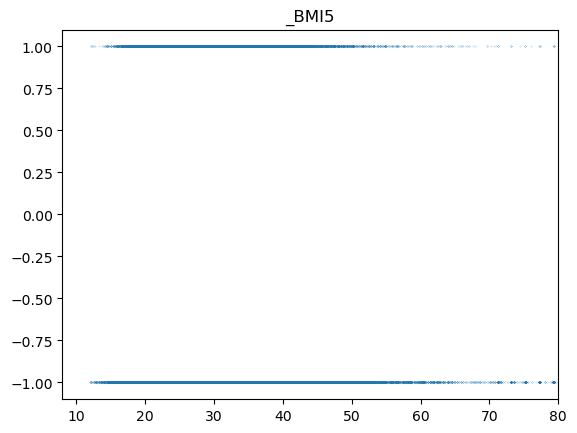

In [56]:
def extract_feature(name):
    filename = 'data/dataset/x_train.csv'
    first_line = np.array(read_first_line(filename))
    index = np.where(first_line == name)
    ind = index[0].item()
    return x_train[:, ind-1]
    
#here is the plot for one of them 
x_extracted = extract_feature('_BMI5')
plt.scatter(x_extracted, y_train, s=0.01)
plt.title('_BMI5')
plt.xlim(8, 80)
plt.show()

Here is a quick method to see that our data is not "clean". There are a lot of nan.

In [131]:
def caracteristics(x, y):
    count = np.sum(~np.isnan(x))
    print("Number of x features beeing not nan:", count)
    nan_count = np.sum(np.isnan(x))
    print("Number of x features beeing nan:", nan_count)
    num_negatives = np.sum(y == -1)
    print("Number of y -1s:", num_negatives)
    num_positives = np.sum(y == 1)
    print("Number of y 1s:", num_positives)
    nan_count_y = np.sum(np.isnan(y))
    print("Number of y nan:", nan_count_y)

#Here is for the specific feature "_BMI5"
caracteristics(x_extracted,y_train)

Number of x features beeing not nan: 301062
Number of x features beeing nan: 27073
Number of y -1s: 299160
Number of y 1s: 28975
Number of y nan: 0


The first approach is to replace them by the mean of the other values

In [58]:
#The first case is for continuous feature
def replace_mean(x):
    mean_value = np.nanmean(x)
    x_new = x.copy()
    x_new[np.isnan(x_new)] = mean_value
    return x_new
#The second case is for discrete feature
#"values" corresponds to the values that are not actual values but correspond to "lack of data"
def replace_with_mean_excluding_values(x, values):
    # Calculate the mean of x excluding values
    mean_without_values = np.nanmean(np.where(np.isin(x, values), np.nan, x))
    # Replace values in x with the calculated mean
    x_new = np.where(np.isin(x, values) | np.isnan(x), mean_without_values, x)
    return x_new

Now we are ready to extract a few features and replace the lack of data with the mean (those features are taken from the website: https://medium.com/@alexteboul17/building-predictive-models-for-heart-disease-using-the-2015-behavioral-risk-factor-surveillance-b786368021ab

In [219]:
_RFCHOL = extract_feature('_RFCHOL')
_SMOKER3 = extract_feature('_SMOKER3')

In [224]:
np.unique(_SMOKER3)

array([-2.41799901, -1.37501693, -0.33203485,  0.71094723,         nan])

In [222]:
################Body mass idex - continuous feature
_BMI5 = extract_feature('_BMI5')
_BMI5, _BMI5_mean, _BMI5_std = standardize(_BMI5)

################High blood pressure - categorical feature (1 = no, 2 = yes, 9 = missing)
_RFHYPE5 = extract_feature('_RFHYPE5')
_RFHYPE5[_RFHYPE5 == 9] = np.nan
_RFHYPE5[_RFHYPE5 == 1] = 0
_RFHYPE5[_RFHYPE5 == 2] = 1

################High cholesterol - categorical feature (1 = no, 2 = yes, 9 = missing)
_RFCHOL = extract_feature('_RFCHOL')
_RFCHOL[_RFCHOL == 9] = np.nan
_RFCHOL[_RFCHOL == 1] = 0
_RFCHOL[_RFCHOL == 2] = 1

################Smoking status - categorical feature (1 = every day, 2 = some days, 3 = formerly, 4 = never, 9 = missing)
_SMOKER3 = extract_feature('_SMOKER3')
_SMOKER3[_SMOKER3 == 9] = np.nan
_SMOKER3, _SMOKER3_mean, _SMOKER3_std = standardize(_SMOKER3)

################Has ever had a stroke  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
CVDSTRK3 = extract_feature('CVDSTRK3')
CVDSTRK3[CVDSTRK3 == 9] = np.nan
CVDSTRK3[CVDSTRK3 == 7] = np.nan
CVDSTRK3[CVDSTRK3 == 2] = 0

################Cholesterol checked  - categorical feature (1 = within the last 5 years, 2 = more than 5 years ago, 3 = never, 9 = missing)
_CHOLCHK = extract_feature('_CHOLCHK')
_CHOLCHK[_CHOLCHK == 9] = np.nan
_CHOLCHK[_CHOLCHK == 3] = 0
_CHOLCHK[_CHOLCHK == 2] = 0
_CHOLCHK[_CHOLCHK == 1] = 1

################Has ever had diabetes  - categorical feature (1 = yes, 2 = yes*, 3 = no, 4 = no - pre-diabetes, 7 = don't know, 9 = missing)
DIABETE3 = extract_feature('DIABETE3')
DIABETE3[DIABETE3 == 9] = np.nan
DIABETE3[DIABETE3 == 7] = np.nan
DIABETE3[DIABETE3 == 3] = 0
DIABETE3[DIABETE3 == 4] = 0
DIABETE3[DIABETE3 == 2] = 1

################Physical activity index  - categorical feature (1 = highly active, 2 = active, 3 = insufficiently active, 4 = inactive, 9 = missing)
_PACAT1 = extract_feature('_PACAT1')
_PACAT1[_PACAT1 == 9] = np.nan
_PACAT1, _PACAT1_mean, _PACAT1_std = standardize(_PACAT1)

################Total fruits consumed per day  - continuous feature (implied 2 dp)
#_FRUTSUM = extract_feature('_FRUTSUM')

################Total vegetables consumed per day  - continuous feature (implied 2 dp)
#_VEGESUM = extract_feature('_VEGESUM')

################Computed number of drinks of alcohol beverages per week  - continuous feature (99900 = missing)
_DRNKWEK = extract_feature('_DRNKWEK')
_DRNKWEK[_DRNKWEK == 99900] = np.nan
_DRNKWEK, _DRNKWEK_mean, _DRNKWEK_std = standardize(_DRNKWEK)

################Have any healthcare coverage  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
HLTHPLN1 = extract_feature('HLTHPLN1')
HLTHPLN1[HLTHPLN1 == 9] = np.nan
HLTHPLN1[HLTHPLN1 == 7] = np.nan
HLTHPLN1[HLTHPLN1 == 2] = 0

################Could not see doctor because of cost  - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
HLTHPLN1 = extract_feature('HLTHPLN1')
HLTHPLN1[HLTHPLN1 == 9] = np.nan
HLTHPLN1[HLTHPLN1 == 7] = np.nan
HLTHPLN1[HLTHPLN1 == 2] = 0

################General health status  - categorical feature (1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor, 7 = don't know, 9 = missing)
GENHLTH = extract_feature('GENHLTH')
GENHLTH[GENHLTH == 9] = np.nan
GENHLTH[GENHLTH == 7] = np.nan
GENHLTH, GENHLTH_mean, GENHLTH_std = standardize(GENHLTH)

################Number of days mental health not good  - continuous feature (88 = none, 77 = don't know, 99 = refused)
MENTHLTH = extract_feature('MENTHLTH')
MENTHLTH[MENTHLTH == 88] = 0
MENTHLTH[MENTHLTH == 77] = np.nan
MENTHLTH[MENTHLTH == 99] = np.nan
MENTHLTH, MENTHLTH_mean, MENTHLTH_std = standardize(MENTHLTH)

################Number of days physical health not good  - continuous feature (88 = none, 77 = don't know, 99 = refused)
PHYSHLTH = extract_feature('PHYSHLTH')
PHYSHLTH[PHYSHLTH == 88] = 0
PHYSHLTH[PHYSHLTH == 77] = np.nan
PHYSHLTH[PHYSHLTH == 99] = np.nan
PHYSHLTH, PHYSHLTH_mean, PHYSHLTH_std = standardize(PHYSHLTH)

################Difficulty walking or climbing stairs - categorical feature (1 = yes, 2 = no, 7 = don't know, 9 = missing)
DIFFWALK = extract_feature('DIFFWALK')
DIFFWALK[DIFFWALK == 9] = np.nan
DIFFWALK[DIFFWALK == 7] = np.nan
DIFFWALK[DIFFWALK == 2] = 0

################Sex - categorical feature (1 = male, 2 = female)
SEX = extract_feature('SEX')
SEX[SEX == 2] = 0

################Age  - categorical feature (1 = 18-24, ... 13 = 80+, 14 = missing)
_AGEG5YR = extract_feature('_AGEG5YR')
_AGEG5YR[_AGEG5YR == 14] = np.nan
_AGEG5YR, _AGEG5YR_mean, _AGEG5YR_std = standardize(_AGEG5YR)

################Education  - categorical feature (1 = none, ... 6 = college grad, 9 = missing)
EDUCA = extract_feature('EDUCA')
EDUCA[EDUCA == 9] = np.nan
EDUCA, EDUCA_mean, EDUCA_std = standardize(EDUCA)

################Income level  - categorical feature (1 = low, ... 5 = high, 9 = missing)
_INCOMG = extract_feature('_INCOMG')
_INCOMG[_INCOMG == 9] = np.nan
_INCOMG, _INCOMG_mean, _INCOMG_std = standardize(_INCOMG)

#Here we stack the features together to have the our new X
X = np.hstack((_BMI5.reshape(-1, 1), _RFHYPE5.reshape(-1, 1), _RFCHOL.reshape(-1, 1), _SMOKER3.reshape(-1, 1), CVDSTRK3.reshape(-1, 1), 
               _CHOLCHK.reshape(-1, 1), DIABETE3.reshape(-1, 1), _PACAT1.reshape(-1, 1), # _FRUTSUM.reshape(-1, 1), _VEGESUM.reshape(-1, 1), 
               _DRNKWEK.reshape(-1, 1), HLTHPLN1.reshape(-1, 1), GENHLTH.reshape(-1, 1), MENTHLTH.reshape(-1, 1), PHYSHLTH.reshape(-1, 1), 
               DIFFWALK.reshape(-1, 1), SEX.reshape(-1, 1), _AGEG5YR.reshape(-1, 1), EDUCA.reshape(-1, 1)))#, _INCOMG.reshape(-1, 1)))


In [225]:
caracteristics(X, y_train)

Number of x features beeing not nan: 5387267
Number of x features beeing nan: 191028
Number of y -1s: 299160
Number of y 1s: 28975
Number of y nan: 0


In [226]:
nan_count_per_column = np.sum(np.isnan(X), axis=0)

In [227]:
nan_count_per_column

array([27073,   918, 46324, 13266,   737, 11245,   479, 41344, 18967,
        1326,   888,  5359,  7108, 10779,     0,  3943,  1272])

In [228]:
y_train.shape

(328135,)

Here I just wanted to use the functions used in the exercise sessions. So I change from -1 to 0 for y negative so that I can use them

In [229]:
#Change all the elements with -1 by 0
y_train_working = y_train.copy()
y_train_working[y_train_working == -1] = 0
#Make y have the correct shape
y_train_working = y_train_working.reshape(-1, 1)

We split the data into train and val sets

In [230]:
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y_train_working = y_train_working[indices]
split_ratio = 0.9
split_index = int(split_ratio * X.shape[0])
X_train, X_val = X[:split_index], X[split_index:]
y_train_working, y_val_working = y_train_working[:split_index], y_train_working[split_index:]

In [231]:
mask_train = ~np.isnan(X_train).any(axis=1)
X_train = X_train[mask_train]
y_train_working = y_train_working[mask_train]

mask_val = ~np.isnan(X_val).any(axis=1)
X_val = X_val[mask_val]
y_val_working = y_val_working[mask_val]

Now we see that the data is highly unbalanced (by a factor 10). We will sample randomly the "0s" so that there are as many as the "1s"
This is probably stupid, but this first approach has the goal that we have a first working prediction that gives bad results and that we discuss it to improve it later. 

In [205]:
def balance_data(x, y):
    #Balance the data by taking only a certain number of values in y=-1 s.t. the number of y=1 equals the number of y=-1
    
    indices_y_equals_1 = np.where(y == 1)[0]
    indices_y_equals_0 = np.where(y == 0)[0]
    num_positives = np.sum(y == 1)
    num_negatives = np.sum(y == 0)
    selected_indices_neg = np.random.choice(indices_y_equals_0, size=num_positives, replace=False)
    
    selected_indices = np.concatenate((selected_indices_neg, indices_y_equals_1))
    selected_X = x[selected_indices]
    selected_y = y[selected_indices]
    
    return selected_X, selected_y

#X_balanced, y_balanced = balance_data(X, y_train)
#caracteristics(X_balanced, y_balanced)

Now we try logistic regression with gradient descent

In [234]:
def logistic_regression_gradient_descent(y_train, x_train, lambda_, gamma, y_val = None, x_val = None, printing=False):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    losses = []

    # build tx
    tx_train = np.c_[np.ones((y_train.shape[0], 1)), x_train]
    w = np.zeros((tx_train.shape[1], 1))
    #print(tx)
    #print(y)
    if printing == True:
        tx_val = np.c_[np.ones((y_val.shape[0], 1)), x_val]


    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent_ridge(y_train, tx_train, w, gamma, lambda_)
        # log info
        if iter % 1000 == 0 and printing == True:
            print("Current iteration={i}, train_loss={l}".format(i=iter, l=loss))
            print("Current iteration={i}, val_loss={l}".format(i=iter, l=calculate_loss(y_val, tx_val, w)))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    return w, loss


In [235]:
#Small test if it's working
lambda_ = 0.0001
gamma = 0.008
logistic_regression_gradient_descent(y_train=y_train_working, x_train=X_train, lambda_=lambda_, gamma=gamma, y_val=y_val_working, x_val=X_val, printing=True)

Current iteration=0, train_loss=0.6931471805599094
Current iteration=0, val_loss=0.688784031218719
Current iteration=1000, train_loss=0.2927080086550358
Current iteration=1000, val_loss=0.293282979636002
Current iteration=2000, train_loss=0.27644166725892216
Current iteration=2000, val_loss=0.2763173966824201
Current iteration=3000, train_loss=0.2686571624129299
Current iteration=3000, val_loss=0.2680377883705867
Current iteration=4000, train_loss=0.26395609951119703
Current iteration=4000, val_loss=0.26296104427421724
Current iteration=5000, train_loss=0.26080985578159405
Current iteration=5000, val_loss=0.2595172826602631
Current iteration=6000, train_loss=0.2585671820302219
Current iteration=6000, val_loss=0.2570332778842315
Current iteration=7000, train_loss=0.2568979468217969
Current iteration=7000, val_loss=0.25516503653041905
Current iteration=8000, train_loss=0.255615466627937
Current iteration=8000, val_loss=0.2537163172052467
Current iteration=9000, train_loss=0.2546056961126

(array([[-1.42076503],
        [ 0.05156306],
        [ 0.30799209],
        [ 0.34179072],
        [-0.15410666],
        [ 0.43236324],
        [-1.04348078],
        [ 0.23927879],
        [-0.0382996 ],
        [-0.04171868],
        [-0.98662942],
        [ 0.56351237],
        [ 0.00575629],
        [ 0.05384919],
        [ 0.13958552],
        [ 0.32276404],
        [ 0.87205497],
        [-0.00348955]]),
 0.2537955321156456)

Now we try to do the same using the k_fold to guess the best lambda (gamma fixed for now -> I dont want to loop on every gamma yet because it would make the final program really slow to run

In [236]:
def cross_validation(y, x, k_indices, k, lambda_, gamma):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    
    w, loss_tr = logistic_regression_gradient_descent(y_tr, x_tr, lambda_, gamma)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************
    tx_te = np.c_[np.ones((y_te.shape[0], 1)), x_te]
    loss_te = calculate_loss(y_te, tx_te, w)
    
    return w, loss_tr, loss_te

And the final function that call the other

In [239]:
def cross_validation_lambdas(y, x, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.

    Args:
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_loss : scalar, the associated root mean squared error for the best lambda
        best_w
    """
    k_fold = k_fold
    lambdas = lambdas
    gamma = 0.008
    # split data in k fold
    k_indices = build_k_indices(y, k_fold)
    # define lists to store the loss of training data and test data
    loss_tr = []
    loss_te = []
    # cross validation over lambdas
    for lambda_ in lambdas:
        print(lambda_)
        loss_tr_tmp = []
        loss_te_tmp = []
        for k in range(k_fold):
            print(k)
            w, loss_tr_tmp_val, loss_te_tmp_val = cross_validation(y, x, k_indices, k, lambda_, gamma)
            loss_tr_tmp.append(loss_tr_tmp_val)
            loss_te_tmp.append(loss_te_tmp_val)
        loss_tr.append(np.mean(loss_tr_tmp))  # Appending mean to the list
        loss_te.append(np.mean(loss_te_tmp))  # Appending mean to the list
        
    best_loss = np.min(loss_te)
    best_lambda = lambdas[np.argmin(loss_te)]
    print(best_loss)
    print(best_lambda)
    return w, best_lambda, best_loss

In [ ]:
k = 10
lambdas = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9])
cross_validation_lambdas(y_train_working, X_train, k, lambdas)

In [88]:
gamma = 0.008
lamda_ = 0.0001
k_fold = 10
# split data in k fold
k_indices = build_k_indices(y_final, k_fold)
loss_tr = 0
loss_te = 0
loss_tr_tmp = []
loss_te_tmp = []
ws = []
for k in range(k_fold):
    w, loss_tr_tmp_val, loss_te_tmp_val = cross_validation(y_final, X_final, k_indices, k, lambda_, gamma)
    loss_tr_tmp.append(loss_tr_tmp_val)
    loss_te_tmp.append(loss_te_tmp_val)
    ws.append(w)
loss_tr = np.mean(loss_tr_tmp)
loss_te = np.mean(loss_te_tmp)
print(ws)
# Stack the arrays along a new axis (axis=2) to align components
stacked_arrays = np.stack(ws, axis=2)
# Calculate the mean along the third axis (axis=2)
w_final = np.mean(stacked_arrays, axis=2)
print(w_final)

Current iteration=0, loss=0.6931471805599465
Current iteration=1000, loss=0.5759364534909579
Current iteration=2000, loss=0.5736866109878641
Current iteration=3000, loss=0.5735058547358677
Current iteration=0, loss=0.6931471805599465
Current iteration=1000, loss=0.5769157352482289
Current iteration=2000, loss=0.5746637560729676
Current iteration=3000, loss=0.5744791942312685
Current iteration=0, loss=0.6931471805599465
Current iteration=1000, loss=0.5752434925589117
Current iteration=2000, loss=0.5729165110626362
Current iteration=3000, loss=0.5727230677676072
Current iteration=0, loss=0.6931471805599465
Current iteration=1000, loss=0.5756315845187144
Current iteration=2000, loss=0.573358351878043
Current iteration=3000, loss=0.5731755653502179
Current iteration=0, loss=0.6931471805599465
Current iteration=1000, loss=0.576594058698112
Current iteration=2000, loss=0.5743020153365053
Current iteration=3000, loss=0.5741110333104809
Current iteration=0, loss=0.6931471805599466
Current iter

Now we want to use our w to predict the results: we first format our x_test values

In [99]:
def extract_feature_test(name):
    filename = 'x_test.csv'
    first_line = np.array(read_first_line(filename))
    index = np.where(first_line == name)
    ind = index[0].item()
    return x_test[:, ind-1]

_BMI5_test = extract_feature_test('_BMI5')
_BMI5_transformed_test = replace_mean(_BMI5_test)

############### High blood pressure (9 = missing)
_RFHYPE5_test = extract_feature_test('_RFHYPE5')
_RFHYPE5_transformed_test = replace_mean(_RFHYPE5_test)
_RFHYPE5_transformed_test = replace_with_mean_excluding_values(_RFHYPE5_test, np.array([9]))

################ High cholesterol
TOLDHI2_test = extract_feature_test('TOLDHI2')
TOLDHI2_transformed_test = replace_mean(TOLDHI2_test)
TOLDHI2_transformed_test = replace_with_mean_excluding_values(TOLDHI2_test, np.array([7, 9]))

################ Smoking
_SMOKER3_test = extract_feature_test('_SMOKER3')
_SMOKER3_transformed_test = replace_mean(_SMOKER3_test)
_SMOKER3_transformed_test = replace_with_mean_excluding_values(_SMOKER3_test, np.array([7, 9]))

################ Has ever had a stroke
CVDSTRK3_test = extract_feature_test('CVDSTRK3')
CVDSTRK3_transformed_test = replace_mean(CVDSTRK3_test)
CVDSTRK3_transformed_test = replace_with_mean_excluding_values(CVDSTRK3_test, np.array([7, 9]))

X_test = np.hstack((_BMI5_transformed_test.reshape(-1, 1), _RFHYPE5_transformed_test.reshape(-1, 1), TOLDHI2_transformed_test.reshape(-1, 1), _SMOKER3_transformed_test.reshape(-1, 1), CVDSTRK3_transformed_test.reshape(-1, 1)))
print(X_test)
print(w_final)

[[22.3         2.          1.          4.          2.        ]
 [21.93        1.          2.          4.          2.        ]
 [28.03849189  2.          2.          4.          2.        ]
 ...
 [24.8         1.          2.          3.          2.        ]
 [23.99        1.          1.58073189  3.          2.        ]
 [42.18        2.          1.          4.          2.        ]]
[[ 0.02388678]
 [ 0.03411269]
 [ 0.65128871]
 [-0.42831283]
 [-0.21467387]
 [-0.51024742]]


Now we actually want to predict

In [100]:
def prediction(tx_test, w):
    compute = sigmoid(np.dot(tx_test, w))
    y_test = (compute >= 0.5).astype(int)
    return y_test

In [103]:
tx_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
print(tx_test)
print(w_final)
y_pred = prediction(tx_test, w_final)
print(y_pred)
y_pred[y_pred == 0] = -1

[[ 1.         22.3         2.          1.          4.          2.        ]
 [ 1.         21.93        1.          2.          4.          2.        ]
 [ 1.         28.03849189  2.          2.          4.          2.        ]
 ...
 [ 1.         24.8         1.          2.          3.          2.        ]
 [ 1.         23.99        1.          1.58073189  3.          2.        ]
 [ 1.         42.18        2.          1.          4.          2.        ]]
[[ 0.02388678]
 [ 0.03411269]
 [ 0.65128871]
 [-0.42831283]
 [-0.21467387]
 [-0.51024742]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]


In [104]:
from helpers import create_csv_submission
create_csv_submission(test_ids, y_pred, "Submission_2")